In [3]:
from IPython.display import SVG
SVG('../Images/DDPG.svg')

![](Images/DDPG_2.png)

In [3]:
import numpy as np
import csv
import os
import math
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam
# import tensorflow_probability as tfp
import collections
import gymnasium as gym

class CriticNetwork(tf.keras.Model):
    def __init__(self, fc1_dims=512, fc2_dims=512):
        super(CriticNetwork, self).__init__() # The purpose of this line is to ensure that the constructor(__init__()) of the parent class (tf.keras.Model) is executed before the additional initialization specific to the CriticNetwork class. 
        self.layer_one_neurons = fc1_dims
        self.layer_two_neurons = fc2_dims
        
        self.first_layer = Dense(self.layer_one_neurons, activation='relu')
        self.second_layer = Dense(self.layer_two_neurons, activation='relu')
        self.critic_layer = Dense(1, activation=None) # Critic Layer

    def call(self, state, action):
        q_value = self.first_layer(tf.concat([state,action],axis=1))
        q_value = self.second_layer(q_value)

        q_value = self.critic_layer(q_value)
        return q_value


class ActorNetwork(tf.keras.Model):
    def __init__(self, n_actions, fc1_dims=512, fc2_dims=512):
        super(ActorNetwork, self).__init__()
        self.layer_one_neurons = fc1_dims
        self.layer_two_neurons = fc2_dims

        self.first_layer = Dense(self.layer_one_neurons, activation='relu')
        self.second_layer = Dense(self.layer_two_neurons, activation='relu')
        self.actor_layer = Dense(n_actions, activation='tanh') # Actor Layer, we have use tanh because we want to bound our actions btw +/-1

    def call(self, state):
        prob = self.first_layer(state)
        prob = self.second_layer(prob)

        actions = self.actor_layer(prob)
        return actions
    

class ReplayBuffer():
    def __init__(self, buffer_limit):
        self.buffer = collections.deque(maxlen=buffer_limit)
        self.memory_count = 0

    def store_transition(self, transition):
        self.buffer.append(transition)
        self.memory_count += 1

    def sample_buffer(self, batch_size):
        mini_batch = np.random.choice(self.memory_count,batch_size,replace=False) # replace=False, means once a memory is sampled we won't sample it again
        states_list, actions_list, rewards_list, next_states_list, done_list = [], [], [], [], []
        
        for sample in mini_batch:
            x_0, a_0, r_1, x_1, terminal = self.buffer[sample]
            states_list.append(x_0)
            actions_list.append(a_0)
            rewards_list.append(r_1)
            next_states_list.append(x_1)
            done_list.append(terminal)

        states = tf.convert_to_tensor(np.array(states_list), dtype=tf.float32)
        actions = tf.convert_to_tensor(np.array(actions_list), dtype=tf.float32)
        rewards = tf.convert_to_tensor(np.array(rewards_list), dtype=tf.float32)
        next_states = tf.convert_to_tensor(np.array(next_states_list), dtype=tf.float32)
        done = np.array(done_list,dtype=np.int32)
        return states, actions, rewards, next_states, done 

In [ ]:
alpha_actor = 0.0003
alpha_critic = 0.001
gamma = 0.99
nb_episodes = 300  # we have to train it for more no of episodes as we have two networks
mini_batch_size = 64  # size of mini-batches
memory_size = 1000000  # capacity of buffer memory
std=0.1
tau=0.005
learning_start = 500

env = gym.make('Pendulum-v1')
state = env.reset()[0]
n_actions = env.action_space.shape[0]
max_action = env.action_space.high[0]
min_action = env.action_space.low[0]

"""
This code checks if GPUs are available and sets GPU memory growth to allow dynamic memory allocation. 
If no GPU is found, it prints a message indicating that no GPU devices were detected.
"""
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    print("No GPU devices found.")

# Define Critic Network
critic = CriticNetwork(fc1_dims=400, fc2_dims=300)

# Define Actor Network
actor = ActorNetwork(n_actions=n_actions, fc1_dims=400, fc2_dims=300)  

# Define Target Actor Network
target_critic = CriticNetwork(fc1_dims=400, fc2_dims=300)

# Define Target Critic Network
target_actor = ActorNetwork(n_actions=n_actions, fc1_dims=400, fc2_dims=300)

# compile all 4 Networks
critic.compile(optimizer=Adam(learning_rate=alpha_critic))
actor.compile(optimizer=Adam(learning_rate=alpha_actor))
target_critic.compile(optimizer=Adam(learning_rate=alpha_critic))
target_actor.compile(optimizer=Adam(learning_rate=alpha_actor))

# To hard copy weights we have to first pass some data from the network, so, that it can create the weights
critic.call(tf.convert_to_tensor([state], dtype=tf.float32),tf.convert_to_tensor([env.action_space.high]))
actor.call(tf.convert_to_tensor([state], dtype=tf.float32))
target_critic.call(tf.convert_to_tensor([state], dtype=tf.float32),tf.convert_to_tensor([env.action_space.high]))
target_actor.call(tf.convert_to_tensor([state], dtype=tf.float32))

target_critic.set_weights(critic.get_weights())  # initial hard update target network weights 
target_actor.set_weights(actor.get_weights())  # initial hard update target network weights 

# Buffer memory 
replay_memory = ReplayBuffer(memory_size)

reward_history = []
avg_reward_history = []
critic_loss_history = []
actor_loss_history = []

best_reward = env.reward_range[0]

directory_name = os.path.join(os.getcwd(), '../Model/DDPG/')

for j in range(nb_episodes): 
    steps = 0
    state = env.reset()[0]
    reward_per_episode = 0
    
    while True:
        if replay_memory.memory_count < learning_start:
            action = env.action_space.sample()
        else:
            action = actor.call(tf.convert_to_tensor([state], dtype=tf.float32))
            action_noise = tf.clip_by_value(tf.random.normal(shape=[n_actions],mean=0.0,stddev=std), -0.5, 0.5)
            
            # adding noise to the action
            action = tf.clip_by_value(action + action_noise, min_action, max_action)[0] # if after adding the noise our action crosses the upper and lower bound of our action space, then we have to limit it

        next_state,reward,done,truncated,_ = env.step(action)

        reward_per_episode += reward
        
        # storing data in buffer memory
        replay_memory.store_transition((state,action,reward,next_state,int(done or truncated)))
        
        # once buffer memory size is greater then equal to learning_start size, then use target-network for target prediction        
        if replay_memory.memory_count > learning_start:
            # sample data from buffer memory numpy arrays and converting it into tensorflow tensors
            state_vector, action_vector, reward_vector, next_state_vector, done_vector = replay_memory.sample_buffer(mini_batch_size)  # randomly sample mini-batch
            
            with tf.GradientTape() as tape:
                # tape.watch(critic.trainable_variables) # this will avoid chain rule
                target_actions = target_actor.call(next_state_vector)  # μ(x_{i+1},θ_)
                target_q_values = tf.squeeze(target_critic.call(next_state_vector,target_actions),1)  # q(x_{i+1},μ(x_{i+1},θ_),W_)
                
                q_values = tf.squeeze(critic.call(state_vector,action_vector),1) # q(x_{i},u_{i},W) -> dimension = (batch_size,no_of_action)

                target = reward_vector + gamma * target_q_values * (1-done_vector)

                critic_loss = tf.keras.losses.MSE(target, q_values)  # L(W) = Σ[Y - q(x_{i},u_{i},W)]^2/n
                critic_network_gradient = tape.gradient(critic_loss,critic.trainable_variables)  # gradient of cost function -> ∇L(W)
                critic.optimizer.apply_gradients(zip(critic_network_gradient,critic.trainable_variables)) # update weight vector using ADAMS, W_{i+1} = W_{i} - α.∇L(W)

                critic_loss_history.append(critic_loss.numpy()) # storing critic loss
                
            with tf.GradientTape() as tape:
                tape.watch(actor.trainable_variables) # watch() is used to start tracing Tensor weights, θ
                policy_actions = actor.call(state_vector)  # μ(x_{i},θ)

                actor_loss = tf.math.reduce_mean(-critic.call(state_vector, policy_actions))  # L(θ) = Σ[q(x_{i},μ(x_{i},θ),W)]/n
                actor_network_gradient = tape.gradient(actor_loss,actor.trainable_variables)  # gradient of cost function -> ∇L(θ)
                actor.optimizer.apply_gradients(zip(actor_network_gradient,actor.trainable_variables)) # update weight vector using ADAMS, θ_{i+1} = θ_{i} - α.∇L(θ)

                actor_loss_history.append(actor_loss.numpy()) # storing actor loss
            
            ## Soft update target network weights
            W = critic.weights  # get Critic weights
            θ = actor.weights  # get Actor weights

            W_ = target_critic.weights  # get target_critic weights
            θ_ = target_actor.weights  # get target_actor weights
            
            for idx,_ in enumerate(W):
                W_[idx] = (1-tau) * W_[idx] + tau * W[idx] # calculate updated target_critic weights

            for idx,_ in enumerate(θ):
                θ_[idx] = (1-tau) * θ_[idx] + tau * θ[idx] # calculate updated target_actor weights

            target_critic.set_weights(W_) # set target_critic weights
            target_actor.set_weights(θ_) # set target_actor weights  
        
        state = next_state # update states
        steps += 1 
       
        if done or truncated:
            reward_history.append(reward_per_episode)   
            avg_reward = np.mean(reward_history[-100:])
            avg_reward_history.append(avg_reward) 

            print("Average reward for",j,"episode and",steps,"steps:",avg_reward)
            
            if avg_reward > best_reward:
                best_reward = avg_reward
                critic.save_weights(os.path.join(directory_name,'critic_network.h5'))
                actor.save_weights(os.path.join(directory_name,'actor_network.h5'))
                target_critic.save_weights(os.path.join(directory_name,'target_critic_network.h5'))
                target_actor.save_weights(os.path.join(directory_name,'target_actor_network.h5'))
            break # start new episode     

# Save the state data as ".csv" for plotting
with open(os.path.join(directory_name,"Data_DDPG.csv"),'w') as csvfile:  
    csvwriter = csv.writer(csvfile)
    csvwriter.writerows([reward_history])
    csvwriter.writerows([avg_reward_history])
    csvwriter.writerows([critic_loss_history])
    csvwriter.writerows([actor_loss_history])

2024-11-27 18:39:24.558389: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-27 18:39:24.572453: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-27 18:39:24.572548: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Average reward for 0 episode and 200 steps: -1436.3906048835822
Average reward for 1 episode and 200 steps: -1241.6593328860056


2024-11-27 18:39:24.841321: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x253e8ec0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-27 18:39:24.841339: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-11-27 18:39:24.843655: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-27 18:39:24.849649: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-11-27 18:39:24.903640: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Average reward for 2 episode and 200 steps: -1326.154010996898
Average reward for 3 episode and 200 steps: -1447.3632124994947
Average reward for 4 episode and 200 steps: -1504.8631623405665
Average reward for 5 episode and 200 steps: -1495.0564222289934
Average reward for 6 episode and 200 steps: -1493.596929987918
Average reward for 7 episode and 200 steps: -1491.3675943716044
Average reward for 8 episode and 200 steps: -1471.586216838892
Average reward for 9 episode and 200 steps: -1449.6113381404473
Average reward for 10 episode and 200 steps: -1385.1393325750857
Average reward for 11 episode and 200 steps: -1348.0751011204372
Average reward for 12 episode and 200 steps: -1311.9800806982296
Average reward for 13 episode and 200 steps: -1263.2192006534854
Average reward for 14 episode and 200 steps: -1214.5878065346417
Average reward for 15 episode and 200 steps: -1212.7127730320017
Average reward for 16 episode and 200 steps: -1219.1526527863805
Average reward for 17 episode and 20

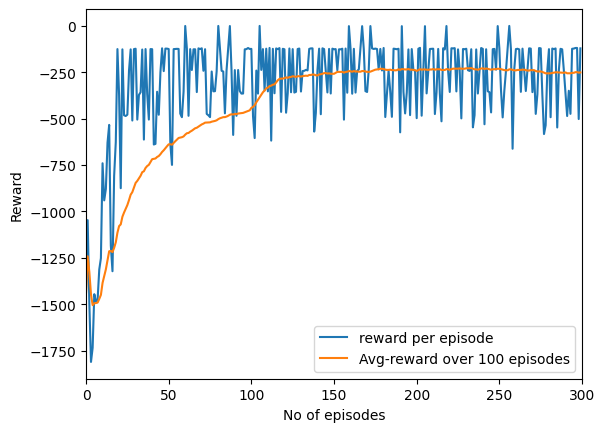

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import os

directory_name = os.path.join(os.getcwd(), '../Model/DDPG/')

# opening the CSV file
with open(os.path.join(directory_name,"Data_DDPG.csv"), mode ='r') as file:
  csvFile = csv.reader(file)
  Pendulum_data = list(csvFile)
  
plt.figure(1)
plt.plot(range(len(Pendulum_data[0])),list(map(float, Pendulum_data[0])),label ='reward per episode')
plt.plot(range(len(Pendulum_data[1])),list(map(float, Pendulum_data[1])),label ='Avg-reward over 100 episodes')
plt.xlabel('No of episodes')
plt.ylabel('Reward')
plt.xlim([0, len(Pendulum_data[1])])
plt.legend()

In [ ]:
import numpy as np
import tensorflow as tf
import gymnasium as gym
import os

directory_name = os.path.join(os.getcwd(), '../Model/DDPG/')

env = gym.make('Pendulum-v1',render_mode='human')
state = env.reset()[0]
n_actions = env.action_space.shape[0]
max_action = env.action_space.high[0]
min_action = env.action_space.low[0]

# define ANN topology
actor = ActorNetwork(n_actions=n_actions, fc1_dims=400, fc2_dims=300) 

actor.build(input_shape=(1,3))

actor.load_weights(os.path.join(directory_name,"actor_network.h5"))

while True:
    action = actor.call(tf.convert_to_tensor([state], dtype=tf.float32))
    action = tf.clip_by_value(action,min_action,max_action)[0]
    state, reward, done, terminated, _ = env.step(action)
    if done or terminated:
        break
env.close()